In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
from torch.nn.utils import prune
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
import random
import sklearn.metrics as perf
import os
import cv2
import time
import torch_pruning as tp
import csv

from models.models import MTLClassifier, AgeRegressor, GenderClassifier, EthnicityClassifier
from utils.data import FacesDataset, data_transform
from utils.training import train_mtl_model, train_age_model, train_gender_model, train_ethnicity_model, train_mtl_model_individual
from utils.evaluation import run_evaluation, show_example_predictions
from utils.pruning import prune_model, prune_other_tasks, get_f1_and_lat

### Load and Prepare Data

In [2]:
### Load in the data
folder = 'UTKFace'
transform = data_transform()
dataset = FacesDataset(folder=folder, transform=transform)

In [3]:
### Set up train and val datasets and loaders
train_len = int(len(dataset)*0.8)
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len], torch.Generator().manual_seed(8))

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

In [4]:
### Get small subset for train_loader and val_loader (for testing and debugging)
# train_indices = torch.randperm(len(train_dataset))[:100]
# val_indices = torch.randperm(len(val_dataset))[:100]
# train_subset = torch.utils.data.Subset(train_dataset, train_indices)
# val_subset = torch.utils.data.Subset(val_dataset, val_indices)
# train_loader = DataLoader(dataset=train_subset, batch_size=16, shuffle=True)
# val_loader = DataLoader(dataset=val_subset, batch_size=16, shuffle=True)

### MTL Model Variants

#### Define pruned training function

In [5]:
def train_initial_mtl_model(num_epochs,
                            train_loader=train_loader, val_loader=val_loader,
                            val_dataset=None):
    
    tasks = ['age', 'gender', 'ethnicity']
    model = MTLClassifier()
    model = model.cuda()
    age_criterion = nn.MSELoss()
    gender_criterion = nn.CrossEntropyLoss()
    ethnicity_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Set up and run model training
    age_coeff = 0.004
    gender_coeff = 2
    ethnicity_coeff = 1

    # Train initial model
    print('---------------- Train Initial Model ----------------')
    save_no_prune = f'Init_MTLModel.pth'
    train_mtl_model(num_epochs=num_epochs, model=model, optimizer=optimizer,
                    train_loader=train_loader, val_loader=val_loader,
                    age_criterion=age_criterion, gender_criterion=gender_criterion, ethnicity_criterion=ethnicity_criterion,
                    age_coeff=age_coeff, gender_coeff=gender_coeff, ethnicity_coeff=ethnicity_coeff, save=True,
                    save_name=save_no_prune)
    
    return 'models/' + save_no_prune


def finetune_mtl_to_task(task, prune_pct, num_epochs,
                         train_loader=train_loader, val_loader=val_loader,
                         val_dataset=None, init_model_path=None):
    
    # Define loss criteria and coefficients
    age_criterion = nn.MSELoss()
    gender_criterion = nn.CrossEntropyLoss()
    ethnicity_criterion = nn.CrossEntropyLoss()
    
    # Load model
    model = torch.load(init_model_path)
    save_initial = f'{task.upper()}_Tuned_MTLModel.pth'
    
    if task.upper() == 'AGE':
        # Do pruning
        pruned_model = prune_other_tasks(model, task1='gender', task2='ethnicity', PRUNING_PERCENT=prune_pct)
        pruned_optimizer = torch.optim.Adam(pruned_model.parameters())
        
        # Fine-tune model
        print('-------------- Fine-tuning Pruned Model -------------')
        train_mtl_model_individual(num_epochs=num_epochs, model=pruned_model, optimizer=pruned_optimizer,
                              train_loader=train_loader, val_loader=val_loader,
                              age_criterion=age_criterion, age_coeff=1.0, gender_coeff=1.0, ethnicity_coeff=1.0,
                              save=True, save_name=save_initial, isAge=True)
        
    elif task.upper() == 'GENDER':
        # Do pruning
        pruned_model = prune_other_tasks(model, task1='age', task2='ethnicity', PRUNING_PERCENT=prune_pct)
        pruned_optimizer = torch.optim.Adam(pruned_model.parameters())
        
        # Fine-tune model
        print('-------------- Fine-tuning Pruned Model -------------')
        train_mtl_model_individual(num_epochs=num_epochs, model=pruned_model, optimizer=pruned_optimizer,
                              train_loader=train_loader, val_loader=val_loader,
                              gender_criterion=gender_criterion, age_coeff=1.0, gender_coeff=1.0, ethnicity_coeff=1.0,
                              save=True, save_name=save_initial, isGender=True)
        
    elif task.upper() == 'ETHNICITY':
        # Do pruning
        pruned_model = prune_other_tasks(model, task1='age', task2='gender', PRUNING_PERCENT=prune_pct)
        pruned_optimizer = torch.optim.Adam(pruned_model.parameters())
        
        # Fine-tune model
        print('-------------- Fine-tuning Pruned Model -------------')
        train_mtl_model_individual(num_epochs=num_epochs, model=pruned_model, optimizer=pruned_optimizer,
                              train_loader=train_loader, val_loader=val_loader,
                              ethnicity_criterion=ethnicity_criterion, age_coeff=1.0, gender_coeff=1.0, ethnicity_coeff=1.0,
                              save=True, save_name=save_initial, isethnicity=True)
    else:
        print('Invalid task was specified. Please specify age, gender, or ethnicity as the task parameter.')
    
    
    
def train_initial_stl_model(task, num_epochs,
                            train_loader=train_loader, val_loader=val_loader,
                            val_dataset=None):
    
    if task.upper() == 'AGE':
        tasks = ['age']
        model = AgeRegressor()
        model = model.cuda()
        age_criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters())

        # Set up and run model training
        # Train initial model
        print('---------------- Train Initial Model ----------------')
        save_no_prune = f'Age_Init_SingleTaskModel.pth'
        train_age_model(num_epochs=num_epochs, model=model, optimizer=optimizer,
                              train_loader=train_loader, val_loader=val_loader,
                              age_criterion=age_criterion, age_coeff=1.0,
                              save=True, save_name=save_no_prune)
        
    elif task.upper() == 'GENDER':
        tasks = ['gender']
        model = GenderClassifier()
        model = model.cuda()
        gender_criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        # Set up and run model training
        # Train initial model
        print('---------------- Train Initial Model ----------------')
        save_no_prune = f'Gender_Init_SingleTaskModel.pth'
        train_gender_model(num_epochs=num_epochs, model=model, optimizer=optimizer,
                           train_loader=train_loader, val_loader=val_loader,
                           gender_criterion=gender_criterion, gender_coeff=1.0,
                           save=True, save_name=save_no_prune)
        
    elif task.upper() == 'ETHNICITY':
        tasks = ['ethnicity']
        model = EthnicityClassifier()
        model = model.cuda()
        ethnicity_criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        # Set up and run model training
        # Train initial model
        print('---------------- Train Initial Model ----------------')
        save_no_prune = f'Ethnicity_Init_SingleTaskModel.pth'
        train_ethnicity_model(num_epochs=num_epochs, model=model, optimizer=optimizer,
                              train_loader=train_loader, val_loader=val_loader,
                              ethnicity_criterion=ethnicity_criterion, ethnicity_coeff=1.0,
                              save=True, save_name=save_no_prune)
    else:
        print('Invalid task was specified. Please specify age, gender, or ethnicity as the task parameter.')
        
    return 'models/' + save_no_prune


def finetune_stl_to_task(task, prune_pct, num_epochs,
                         train_loader=train_loader, val_loader=val_loader,
                         val_dataset=None, init_model_path=None):
    
    model = torch.load(init_model_path)
    save_initial = f'{task.upper()}_Tuned_SingleTaskModel.pth'
    if task.upper() == 'AGE':
        age_criterion = nn.MSELoss()
        
        # Do pruning
        pruned_model = prune_other_tasks(model, task1='gender', task2='ethnicity', PRUNING_PERCENT=prune_pct)
        pruned_optimizer = torch.optim.Adam(pruned_model.parameters())
        
        # Fine-tune model
        print('-------------- Fine-tuning Pruned Model -------------')
        train_age_model(num_epochs=num_epochs, model=pruned_model, optimizer=pruned_optimizer,
                              train_loader=train_loader, val_loader=val_loader,
                              age_criterion=age_criterion, age_coeff=1.0,
                              save=True, save_name=save_initial)
    elif task.upper() == 'GENDER':
        gender_criterion = nn.CrossEntropyLoss()
        
        # Do pruning
        pruned_model = prune_other_tasks(model, task1='age', task2='ethnicity', PRUNING_PERCENT=prune_pct)
        pruned_optimizer = torch.optim.Adam(pruned_model.parameters())
        
        # Fine-tune model
        print('-------------- Fine-tuning Pruned Model -------------')
        train_gender_model(num_epochs=num_epochs, model=pruned_model, optimizer=pruned_optimizer,
                           train_loader=train_loader, val_loader=val_loader,
                           gender_criterion=gender_criterion, gender_coeff=1.0,
                           save=True, save_name=save_initial)
    elif task.upper() == 'ETHNICITY':
        ethnicity_criterion = nn.CrossEntropyLoss()
        
        # Do pruning
        pruned_model = prune_other_tasks(model, task1='age', task2='gender', PRUNING_PERCENT=prune_pct)
        pruned_optimizer = torch.optim.Adam(pruned_model.parameters())
        
        # Fine-tune model
        print('-------------- Fine-tuning Pruned Model -------------')
        train_ethnicity_model(num_epochs=num_epochs, model=pruned_model, optimizer=pruned_optimizer,
                              train_loader=train_loader, val_loader=val_loader,
                              ethnicity_criterion=ethnicity_criterion, ethnicity_coeff=1.0,
                              save=True, save_name=save_initial)
    else:
        print('Invalid task was specified. Please specify age, gender, or ethnicity as the task parameter.')

### Time MTL Training

In [6]:
num_epochs = 10
prune_pct = 0.3  # Chose 0.3 because model performance remains high. Any consistent value would work to measure time difference.

starttime = time.time()

print('Train Initial MTL Model')
# Get initial MTL model
initial_model_path = train_initial_mtl_model(num_epochs=num_epochs,
                                             train_loader=train_loader, val_loader=val_loader,
                                             val_dataset=val_dataset)
print()
print('Fine Tune for Age')
# Fine-tune for Age
finetune_mtl_to_task(task='age', prune_pct=prune_pct, num_epochs=num_epochs,
                     train_loader=train_loader, val_loader=val_loader,
                     val_dataset=val_dataset, init_model_path=initial_model_path)

print()
print('Fine Tune for Gender')
# Fine-tune for Gender
finetune_mtl_to_task(task='gender', prune_pct=prune_pct, num_epochs=num_epochs,
                     train_loader=train_loader, val_loader=val_loader,
                     val_dataset=val_dataset, init_model_path=initial_model_path)

print()
print('Fine Tune for Ethnicity')
# Fine-tune for Ethnicity
finetune_mtl_to_task(task='ethnicity', prune_pct=prune_pct, num_epochs=num_epochs,
                     train_loader=train_loader, val_loader=val_loader,
                     val_dataset=val_dataset, init_model_path=initial_model_path)

print()
mtl_time = time.time() - starttime
print(f'Took {mtl_time}s to train MTL model and fine-tune for the 3 tasks.')

Train Initial MTL Model
---------------- Train Initial Model ----------------
Epoch 0, val loss: inf -> 0.13107, train loss: 0.15704
Epoch 0, age val loss: 0.03031, gender val loss: 0.04290, ethnicity val loss: 0.05786
Epoch 1, val loss: 0.13344, train loss: 0.11092
Epoch 1, age val loss: 0.03041, gender val loss: 0.05094, ethnicity val loss: 0.05209
Epoch 2, val loss: 0.13107 -> 0.08507, train loss: 0.09701
Epoch 2, age val loss: 0.02369, gender val loss: 0.02475, ethnicity val loss: 0.03663
Epoch 3, val loss: 0.08507 -> 0.08034, train loss: 0.08416
Epoch 3, age val loss: 0.01980, gender val loss: 0.02393, ethnicity val loss: 0.03662
Epoch 4, val loss: 0.08040, train loss: 0.07508
Epoch 4, age val loss: 0.01763, gender val loss: 0.02393, ethnicity val loss: 0.03884
Epoch 5, val loss: 0.08813, train loss: 0.06860
Epoch 5, age val loss: 0.01608, gender val loss: 0.02438, ethnicity val loss: 0.04767
Epoch 6, val loss: 0.08651, train loss: 0.05941
Epoch 6, age val loss: 0.01783, gender va

### Time Single Task Training

In [7]:
num_epochs = 10
prune_pct = 0.3  # Chose 0.3 because model performance remains high. Any consistent value would work to measure time difference.

starttime = time.time()

print('Train Initial Age Model')
# Get initial Age model
initial_model_path = train_initial_stl_model(task='age', num_epochs=num_epochs,
                                             train_loader=train_loader, val_loader=val_loader,
                                             val_dataset=val_dataset)
print()
print('Fine Tune Age Model')
# Fine-tune for age
finetune_stl_to_task(task='age', prune_pct=prune_pct, num_epochs=num_epochs,
                     train_loader=train_loader, val_loader=val_loader,
                     val_dataset=val_dataset, init_model_path=initial_model_path)
print()
print('Train Initial Gender Model')
# Get initial Gender model
initial_model_path = train_initial_stl_model(task='gender', num_epochs=num_epochs,
                                             train_loader=train_loader, val_loader=val_loader,
                                             val_dataset=val_dataset)
print()
print('Fine Tune Gender Model')
# Fine-tune for gender
finetune_stl_to_task(task='gender', prune_pct=prune_pct, num_epochs=num_epochs,
                     train_loader=train_loader, val_loader=val_loader,
                     val_dataset=val_dataset, init_model_path=initial_model_path)
print()
print('Train Initial Ethnicity Model')
# Get initial Ethnicity model
initial_model_path = train_initial_stl_model(task='ethnicity', num_epochs=num_epochs,
                                             train_loader=train_loader, val_loader=val_loader,
                                             val_dataset=val_dataset)
print()
print('Fine Tune Ethnicity Model')
# Fine-tune for ethnicity
finetune_stl_to_task(task='ethnicity', prune_pct=prune_pct, num_epochs=num_epochs,
                     train_loader=train_loader, val_loader=val_loader,
                     val_dataset=val_dataset, init_model_path=initial_model_path)

print()
stl_time = time.time() - starttime
print(f'Took {stl_time}s to train Single Task model ands fine-tune for the 3 tasks.')

Train Initial Age Model
---------------- Train Initial Model ----------------
Epoch 0, val loss: inf -> 6.22564, train loss: 10.81758
Epoch 1, val loss: 8.96379, train loss: 6.94658
Epoch 2, val loss: 6.22564 -> 6.17033, train loss: 5.71773
Epoch 3, val loss: 6.17033 -> 5.28838, train loss: 4.88845
Epoch 4, val loss: 6.34183, train loss: 4.38144
Epoch 5, val loss: 5.28838 -> 4.58816, train loss: 3.79184
Epoch 6, val loss: 4.58816 -> 4.38393, train loss: 3.35998
Epoch 7, val loss: 4.38393 -> 4.37747, train loss: 2.87971
Epoch 8, val loss: 4.74174, train loss: 2.50083
Epoch 9, val loss: 4.44484, train loss: 2.27963

Fine Tune Age Model
-------------- Fine-tuning Pruned Model -------------
Epoch 0, val loss: inf -> 4.23545, train loss: 3.51888
Epoch 1, val loss: 4.23545 -> 4.07689, train loss: 2.47861
Epoch 2, val loss: 4.30143, train loss: 2.25735
Epoch 3, val loss: 5.78068, train loss: 2.07149
Epoch 4, val loss: 4.13395, train loss: 2.04451
Epoch 5, val loss: 4.35489, train loss: 1.7833

In [8]:
# MTL Time: 1138.703040838241 s
# STL Time: 1926.8884637355804 s

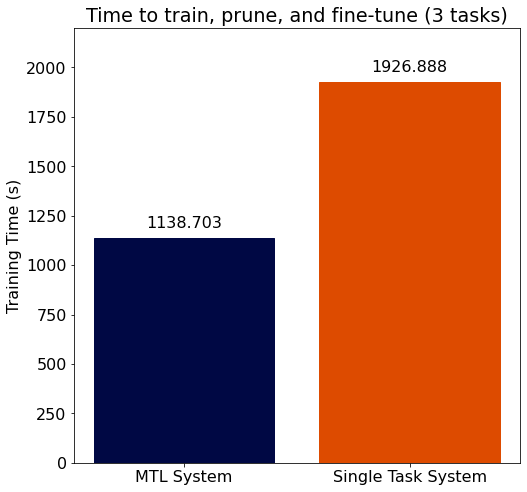

In [54]:
# Generate plot comparing MTL Time and STL Time (bar plot with % difference shown)
mtl_time = 1138.703
stl_time = 1926.888

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 8))
systems = ['MTL System', 'Single Task System']
heights = [mtl_time, stl_time]
bars = ax.bar(systems, heights)
ax.set_title('Time to train, prune, and fine-tune (3 tasks)')
ax.set_ylabel('Training Time (s)')
bars[0].set_color('#000844')
bars[1].set_color('#DD4B00')
ax.set_ylim([0, 2200])

for i in range(len(systems)):
    plt.text(i, heights[i]+50, heights[i], ha = 'center')
    
plt.show()